In [1]:
library(data.table)
library(magrittr)
library(lubridate)
library(ggplot2)
library(cowplot)
library(repr)
library(kableExtra)
library(IRdisplay)

print("All packages loaded successfully")



Attaching package: 'lubridate'


The following objects are masked from 'package:data.table':

    hour, isoweek, mday, minute, month, quarter, second, wday, week,
    yday, year


The following objects are masked from 'package:base':

    date, intersect, setdiff, union



Attaching package: 'cowplot'


The following object is masked from 'package:lubridate':

    stamp




[1] "All packages loaded successfully"


In [2]:
# polices sold between start 2016 to end 2017
dt_policydates <- data.table(date_UW = seq(as.Date("2016/1/1"), as.Date("2017/12/31"), "day"))

# number of policies per day follows Poisson process with mean 700 (approx 255,500 pols per annum)
dt_policydates[, ':='(policycount = rpois(.N,700),
                      date_lapse = date_UW %m+% years(1),
                      expodays = as.integer(date_UW %m+% years(1) - date_UW),
                      pol_prefix = year(date_UW)*10000 + month(date_UW)*100 + mday(date_UW))]


In [3]:
# Add columns defining Policy Covers   
dt_policydates[, Cover_B := round(policycount * 0.25)]
dt_policydates[, Cover_BO := round(policycount * 0.45)]
dt_policydates[, Cover_BOT := policycount - Cover_B - Cover_BO]

In [4]:

kable(head(dt_policydates), "html") %>% 
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

date_UW,policycount,date_lapse,expodays,pol_prefix,Cover_B,Cover_BO,Cover_BOT
2016-01-01,697,2017-01-01,366,20160101,174,314,209
2016-01-02,760,2017-01-02,366,20160102,190,342,228
2016-01-03,699,2017-01-03,366,20160103,175,315,209
2016-01-04,705,2017-01-04,366,20160104,176,317,212
2016-01-05,667,2017-01-05,366,20160105,167,300,200
2016-01-06,637,2017-01-06,366,20160106,159,287,191


In [5]:

# repeat rows for each policy by UW-Date
dt_policy <- dt_policydates[rep(1:.N, policycount),c("date_UW", "pol_prefix"), with = FALSE][,pol_seq:=1:.N, by=pol_prefix]

# Create a unique policy number 
dt_policy[, pol_number := as.character(pol_prefix * 10000 + pol_seq)]

kable(head(dt_policy), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()
     

date_UW,pol_prefix,pol_seq,pol_number
2016-01-01,20160101,1,201601010001
2016-01-01,20160101,2,201601010002
2016-01-01,20160101,3,201601010003
2016-01-01,20160101,4,201601010004
2016-01-01,20160101,5,201601010005
2016-01-01,20160101,6,201601010006


In [6]:

# set join keys
setkey(dt_policy,'date_UW')
setkey(dt_policydates,'date_UW')  

# remove pol_prefix before join
dt_policydates[, pol_prefix := NULL]  

# join cover from summary file (dt_policydates)
dt_policy <- dt_policy[dt_policydates]  

# now create Cover field for each policy row
dt_policy[,Cover := 'BO']
dt_policy[pol_seq <= policycount- Cover_BO,Cover := 'BOT']
dt_policy[pol_seq <= Cover_B,Cover := 'B']  

dt_policy[, Cover_B := as.factor(Cover)]  

# remove interim calculation fields
dt_policy[, ':='(pol_prefix = NULL,
                 policycount = NULL,
                 pol_seq = NULL,
                 Cover_B = NULL,
                 Cover_BOT = NULL,
                 Cover_BO = NULL)]

# check output
kable(head(dt_policy), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()


date_UW,pol_number,date_lapse,expodays,Cover
2016-01-01,201601010001,2017-01-01,366,B
2016-01-01,201601010002,2017-01-01,366,B
2016-01-01,201601010003,2017-01-01,366,B
2016-01-01,201601010004,2017-01-01,366,B
2016-01-01,201601010005,2017-01-01,366,B
2016-01-01,201601010006,2017-01-01,366,B


In [7]:

# Add remaining policy details
dt_policy[, Brand := rep(rep(c(1,2,3,4), c(9,6,3,2)), length.out = .N)]
dt_policy[, Base_Price := rep(rep(c(600,550,300,150), c(9,6,3,2)), length.out = .N)]

# models types and model cost multipliers
for (eachBrand in unique(dt_policy$Brand)) {
  dt_policy[Brand == eachBrand, Model := rep(rep(c(3,2,1,0), c(10, 7, 2, 1)), length.out = .N)]
  dt_policy[Brand == eachBrand, Model_mult := rep(rep(c(1.15^3, 1.15^2, 1.15^1, 1.15^0), c(10, 7, 2, 1)), length.out = .N)]
}

dt_policy[, Price := ceiling (Base_Price * Model_mult)]

# check output
kable(head(dt_policy), "html") %>%
  kable_styling("striped") %>% 
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

date_UW,pol_number,date_lapse,expodays,Cover,Brand,Base_Price,Model,Model_mult,Price
2016-01-01,201601010001,2017-01-01,366,B,1,600,3,1.520875,913
2016-01-01,201601010002,2017-01-01,366,B,1,600,3,1.520875,913
2016-01-01,201601010003,2017-01-01,366,B,1,600,3,1.520875,913
2016-01-01,201601010004,2017-01-01,366,B,1,600,3,1.520875,913
2016-01-01,201601010005,2017-01-01,366,B,1,600,3,1.520875,913
2016-01-01,201601010006,2017-01-01,366,B,1,600,3,1.520875,913


In [8]:
# colums to keep
cols_policy <- c("pol_number",
                 "date_UW",
                 "date_lapse",
                 "Cover",
                 "Brand",
                 "Model",
                 "Price")

dt_policy <- dt_policy[, cols_policy, with = FALSE]

# check output
kable(head(dt_policy), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

save(dt_policy, file = "./dt_policy.rda")

pol_number,date_UW,date_lapse,Cover,Brand,Model,Price
201601010001,2016-01-01,2017-01-01,B,1,3,913
201601010002,2016-01-01,2017-01-01,B,1,3,913
201601010003,2016-01-01,2017-01-01,B,1,3,913
201601010004,2016-01-01,2017-01-01,B,1,3,913
201601010005,2016-01-01,2017-01-01,B,1,3,913
201601010006,2016-01-01,2017-01-01,B,1,3,913


In [9]:

# All policies have breakage cover
# claims uniformly sampled from policies
claim <- sample(nrow(dt_policy), size = floor(nrow(dt_policy) * 0.15))

# Claim severity multiplier sampled from beta distribution
dt_claim <- data.table(pol_number = dt_policy[claim, pol_number],
                       claim_type = 'B',
                       claim_count = 1,
                       claim_sev = rbeta(length(claim), 2,5))

# check output
kable(head(dt_claim), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()
     

pol_number,claim_type,claim_count,claim_sev
201611230151,B,1,0.5015375
201712010022,B,1,0.0924250
201602170058,B,1,0.1414966
201708220050,B,1,0.4140941
201612260646,B,1,0.2723934
201702090454,B,1,0.3714669


In [10]:
# identify all policies with Oxidation cover
cov <- which(dt_policy$Cover != 'B')

# sample claims from policies with cover
claim <- sample(cov, size = floor(length(cov) * 0.05))

# add claims to table 
dt_claim <- rbind(dt_claim,
                  data.table(pol_number = dt_policy[claim, pol_number],
                             claim_type = 'O',
                             claim_count = 1,
                             claim_sev = rbeta(length(claim), 5,3)))

# check output
kable(head(dt_claim), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

pol_number,claim_type,claim_count,claim_sev
201611230151,B,1,0.5015375
201712010022,B,1,0.0924250
201602170058,B,1,0.1414966
201708220050,B,1,0.4140941
201612260646,B,1,0.2723934
201702090454,B,1,0.3714669


In [11]:

# identify all policies with Theft cover
# for Theft claim frequency varies by Brand
# So need to consider each in turn...

for(myModel in 0:3) {

    cov <- which(dt_policy$Cover == 'BOT' & dt_policy$Model == myModel)
    claim <- sample(cov, size = floor(length(cov) * 0.05*(1 + myModel)))
  
    dt_claim <- rbind(dt_claim,
                      data.table(pol_number = dt_policy[claim, pol_number],
                                 claim_type = 'T',
                                 claim_count = 1,
                                 claim_sev = rbeta(length(claim), 5,.5)))
}

# check output
kable(head(dt_claim), "html") %>% 
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

kable(tail(dt_claim), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

pol_number,claim_type,claim_count,claim_sev
201611230151,B,1,0.5015375
201712010022,B,1,0.0924250
201602170058,B,1,0.1414966
201708220050,B,1,0.4140941
201612260646,B,1,0.2723934
201702090454,B,1,0.3714669


pol_number,claim_type,claim_count,claim_sev
201609180319,T,1,0.8353839
201604100192,T,1,0.9994607
201612130367,T,1,0.9789487
201707270345,T,1,0.8719944
201602110353,T,1,0.9317587
201712180323,T,1,0.9968306


In [12]:

# set join keys
setkey(dt_policy, pol_number)
setkey(dt_claim, pol_number)

#join Brand and Price from policy to claim
dt_claim[dt_policy,
         on = 'pol_number',
         ':='(date_UW = i.date_UW,
              Price = i.Price,
              Brand = i.Brand)]

# check output
kable(head(dt_claim), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()
     

pol_number,claim_type,claim_count,claim_sev,date_UW,Price,Brand
201601010002,B,1,0.6889139,2016-01-01,913,1
201601010008,B,1,0.2882500,2016-01-01,913,1
201601010023,B,1,0.5934060,2016-01-01,794,1
201601010034,B,1,0.2729722,2016-01-01,728,2
201601010046,B,1,0.1761531,2016-01-01,913,1
201601010055,B,1,0.1052651,2016-01-01,633,2


In [13]:

# use lubridate %m+% date addition operator 
dt_claim[, date_lapse := date_UW %m+% years(1)]
dt_claim[, expodays := as.integer(date_lapse - date_UW)]
dt_claim[, occ_delay_days := floor(expodays * runif(.N, 0,1))]

dt_claim[ ,delay_report := floor(365 * rbeta(.N, .4, 10))]  
dt_claim[ ,delay_pay := floor(10 + 40* rbeta(.N, 7,7))]  

dt_claim[, date_occur := date_UW %m+% days(occ_delay_days)]
dt_claim[, date_report := date_occur %m+% days(delay_report)]
dt_claim[, date_pay := date_report %m+% days(delay_pay)]

dt_claim[, claim_cost := round(Price * claim_sev)]

In [14]:
# check output
head(dt_claim)

pol_number,claim_type,claim_count,claim_sev,date_UW,Price,Brand,date_lapse,expodays,occ_delay_days,delay_report,delay_pay,date_occur,date_report,date_pay,claim_cost
<chr>,<chr>,<dbl>,<dbl>,<date>,<dbl>,<dbl>,<date>,<int>,<dbl>,<dbl>,<dbl>,<date>,<date>,<date>,<dbl>
201601010002,B,1,0.6889139,2016-01-01,913,1,2017-01-01,366,68,8,27,2016-03-09,2016-03-17,2016-04-13,629
201601010008,B,1,0.2882500,2016-01-01,913,1,2017-01-01,366,259,5,28,2016-09-16,2016-09-21,2016-10-19,263
201601010023,B,1,0.5934060,2016-01-01,794,1,2017-01-01,366,222,31,28,2016-08-10,2016-09-10,2016-10-08,471
201601010034,B,1,0.2729722,2016-01-01,728,2,2017-01-01,366,126,19,28,2016-05-06,2016-05-25,2016-06-22,199
201601010046,B,1,0.1761531,2016-01-01,913,1,2017-01-01,366,85,2,21,2016-03-26,2016-03-28,2016-04-18,161
201601010055,B,1,0.1052651,2016-01-01,633,2,2017-01-01,366,66,5,23,2016-03-07,2016-03-12,2016-04-04,67


In [15]:
# add a unique claimkey based upon occurence date

dt_claim[, clm_prefix := year(date_occur)*10000 + month(date_occur)*100 + mday(date_occur)]
dt_claim[, clm_seq := seq_len(.N), by = clm_prefix]
dt_claim[, clm_number := as.character(clm_prefix * 10000 + clm_seq)]


# keep only first claim against policy (competing hazards)
setkeyv(dt_claim, c("pol_number", "clm_prefix"))
dt_claim[, polclm_seq := seq_len(.N), by = .(pol_number)]
dt_claim <- dt_claim[polclm_seq == 1,]

# colums to keep
cols_claim <- c("clm_number",
                "pol_number",
                "claim_type",
                "claim_count",
                "claim_sev",
                "date_occur",
                "date_report",
                "date_pay",
                "claim_cost")

dt_claim <- dt_claim[, cols_claim, with = FALSE]

# check output
kable(head(dt_claim), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()

save(dt_claim, file = "./dt_claim.rda")

clm_number,pol_number,claim_type,claim_count,claim_sev,date_occur,date_report,date_pay,claim_cost
201603090001,201601010002,B,1,0.6889139,2016-03-09,2016-03-17,2016-04-13,629
201609160001,201601010008,B,1,0.2882500,2016-09-16,2016-09-21,2016-10-19,263
201608100001,201601010023,B,1,0.5934060,2016-08-10,2016-09-10,2016-10-08,471
201605060001,201601010034,B,1,0.2729722,2016-05-06,2016-05-25,2016-06-22,199
201603260001,201601010046,B,1,0.1761531,2016-03-26,2016-03-28,2016-04-18,161
201603070001,201601010055,B,1,0.1052651,2016-03-07,2016-03-12,2016-04-04,67


Warning message:
"The dot-dot notation (`..prop..`) was deprecated in ggplot2 3.4.0.
i Please use `after_stat(prop)` instead."


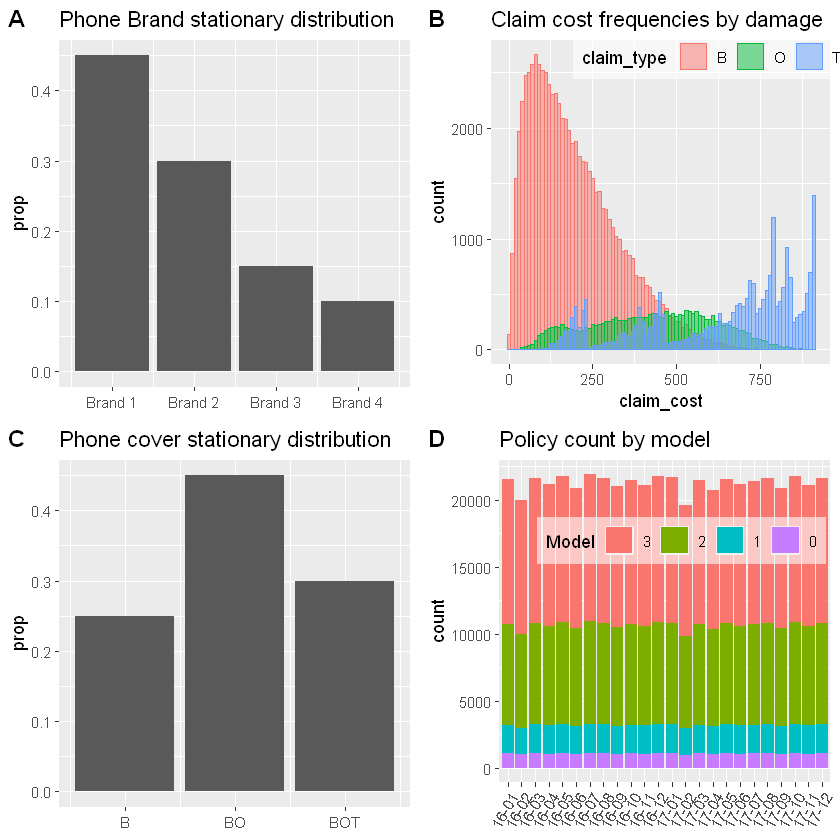

In [16]:

dt_policy[, Cover2 := as.integer(factor(Cover))]

p1 <- ggplot(data = dt_policy, aes(x = Brand, y = ..prop..)) + 
  geom_bar(stat = "count") + 
  labs(title = "Phone Brand stationary distribution", x = NULL) + 
  scale_x_continuous(breaks=c(1,2,3, 4), labels=c("Brand 1", "Brand 2", "Brand 3", "Brand 4"))

p2 <- ggplot(dt_claim, aes(x=claim_cost, fill=claim_type, color=claim_type)) +
  geom_histogram(position="identity", alpha=0.5, binwidth = 10) + 
  labs(title = "Claim cost frequencies by damage") + 
  theme(legend.position = c(.65,.95),
        legend.direction = "horizontal",
        legend.background = element_rect(fill=alpha('white', 0.6)))

p3 <- ggplot(data = dt_policy, aes(x = Cover2, y = ..prop..)) + 
  geom_bar(stat = "count") + 
  labs(title = "Phone cover stationary distribution", x = NULL) + 
  scale_x_continuous(breaks=c(1,2,3), labels=c("B", "BO", "BOT"))

p4 <- ggplot(data = dt_policy, aes(x = format(date_UW, "%y-%m"), fill=factor(Model, levels = c(3,2,1,0)))) + 
  geom_bar(stat = "count") + 
  labs(title = "Policy count by model", x = NULL, fill = "Model") +
  theme(axis.text.x=element_text(angle=60, hjust=1),
        legend.position = c(.55,.75),
        legend.direction = "horizontal",
        legend.background = element_rect(fill=alpha('white', 0.6)))

plot_grid(p1,p2,p3,p4, labels = "AUTO")

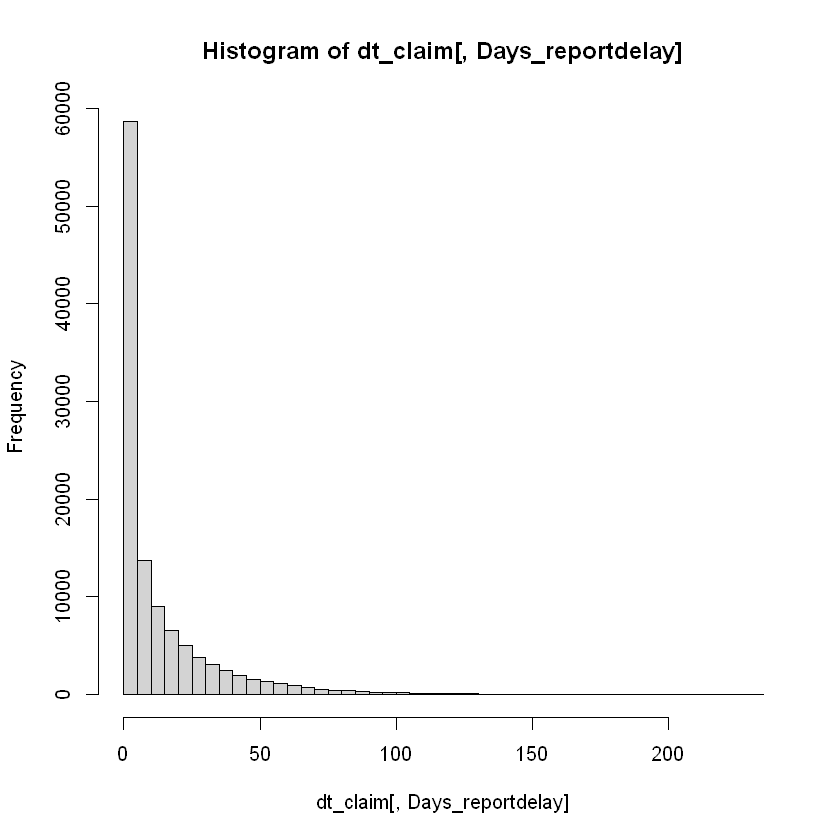

In [17]:
dt_claim[, Days_reportdelay := as.numeric(difftime(date_report, date_occur, units="days"))]


hist(dt_claim[, Days_reportdelay],breaks = 50)

     

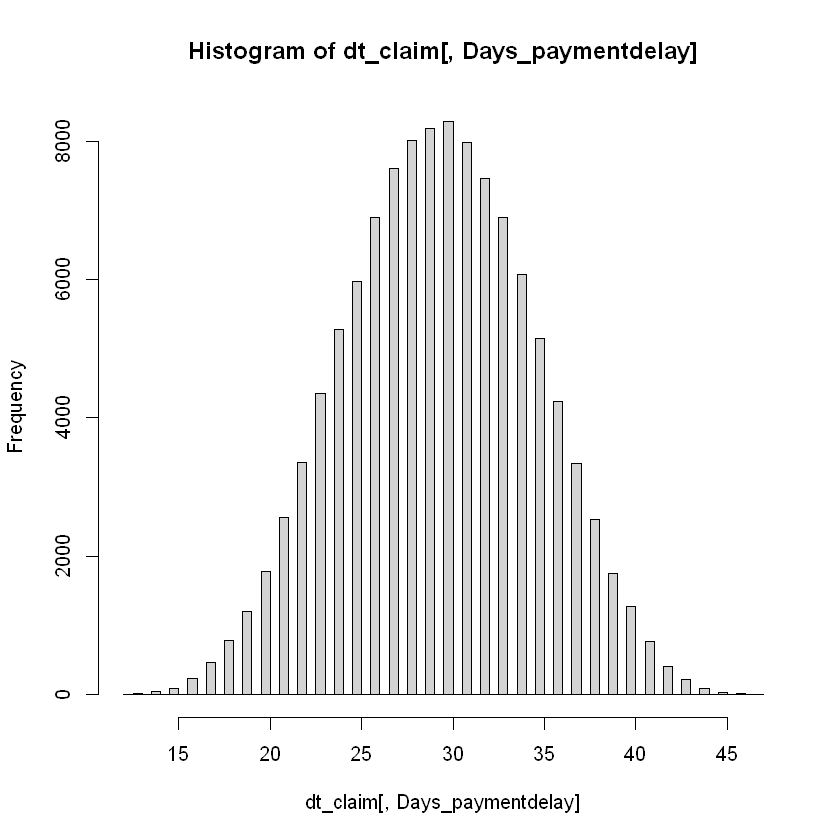

In [18]:
dt_claim[, Days_paymentdelay := as.numeric(difftime(date_pay, date_report, units="days"))]
hist(dt_claim[, Days_paymentdelay],breaks = 60)
     

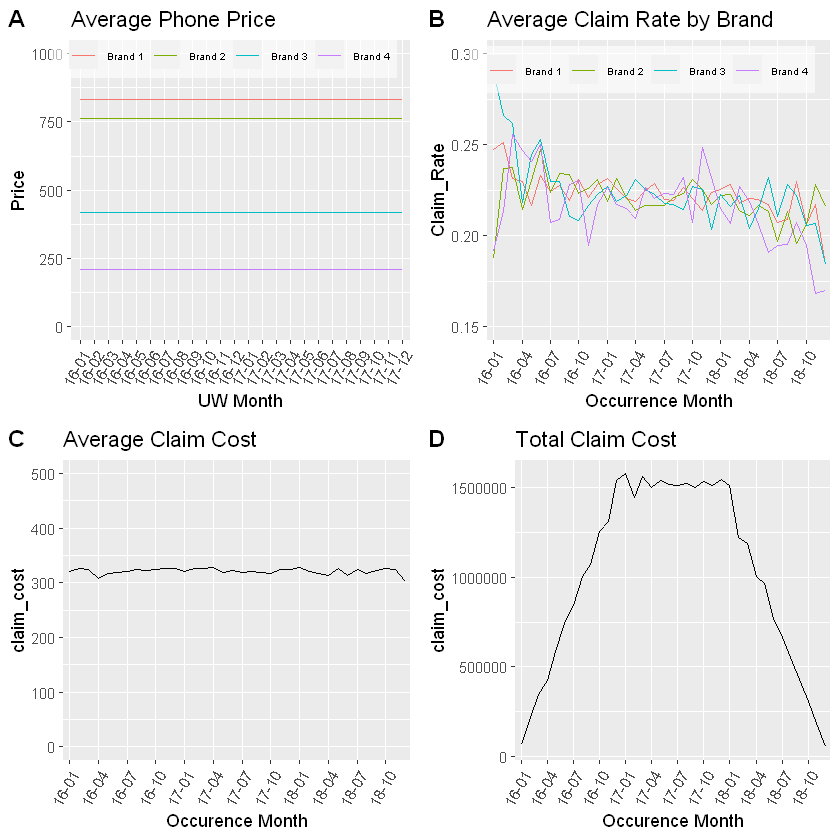

In [19]:
## Exhibits to check output

tmp <- dt_policy[,.(Price = mean(Price)), by = .(Brand = paste0("Brand ", Brand), date_UW=format(date_UW, "%y-%m"))]
p1 <- ggplot(data = tmp, aes(x = date_UW, y = Price, group=factor(Brand))) + 
          geom_line(aes(color = Brand)) + 
          labs(title = "Average Phone Price", x = "UW Month")+
          theme(axis.text.x=element_text(angle=60, hjust=1),
                legend.position = c(.45,.95),
                legend.direction = "horizontal",
                legend.title = element_blank(),
                legend.background = element_rect(fill=alpha('white', 0.6)),
                legend.text = element_text(size = 6)) +
          ylim(0, 1000)

#function to calc policies in force on a date
policy_count <- function(mydate, myBrand){
  dt_policy[date_UW <= mydate & date_lapse >= mydate & Brand == myBrand, .N]
}

#function return every nth axis label
every_nth = function(n) {
  return(function(x) {x[c(TRUE, rep(FALSE, n - 1))]})
}


#create a table to store policy exposures by brand
dt_exposuredates <- NULL
for (eachBrand in unique(dt_policy$Brand)){
  dt_exposuredates <- rbind(dt_exposuredates, data.table(date_Expo = seq(as.Date("2016/1/1"), as.Date("2018/12/31"), "day"),
                                                         Brand = eachBrand))
}

# calculate the exposure
dt_exposuredates[, Expo := mapply(policy_count, date_Expo,Brand)]
# calculate monthly summaries
dt_exposure <- dt_exposuredates[, .(Exposure = sum(Expo)), keyby = .(date_occur=format(date_Expo, "%y-%m"), Brand = paste0("Brand ", Brand)) ]

# add Brand details to Claims details and aggregate to monthly summary
tmp <- dt_policy[dt_claim][,.(claim_cost = sum(claim_cost), claim_count = .N), keyby = .(date_occur=format(date_occur, "%y-%m"), Brand = paste0("Brand ", Brand))]

# add monthly exposures and calculate claim rate
tmp2 <- dt_exposure[tmp][, Claim_Rate := 12 * 30.5 * claim_count / Exposure]

p2 <- ggplot(data = tmp2, aes(x = date_occur, y = Claim_Rate, group=factor(Brand))) + 
  geom_line(aes(color = Brand)) + 
  labs(title = "Average Claim Rate by Brand", x = "Occurrence Month") +
  theme(axis.text.x=element_text(angle=60, hjust=1),
        legend.position = c(.45,.9),
        legend.direction = "horizontal",
        legend.title = element_blank(),
        legend.background = element_rect(fill=alpha('white', 0.6)),
        legend.text = element_text(size = 6)) +
  scale_x_discrete(breaks = every_nth(n = 3)) +
  ylim(0.15, 0.3)


tmp <- dt_claim[,.(claim_cost = mean(claim_cost)), keyby = .(date_occur=format(date_occur, "%y-%m"))]
p3 <- ggplot(data = tmp, aes(date_occur, claim_cost,  group = 1 )) + 
  geom_line() + 
  labs(title = "Average Claim Cost", x = "Occurence Month") +
  theme(axis.text.x=element_text(angle=60, hjust=1))+
  scale_x_discrete(breaks = every_nth(n = 3)) +
  ylim(0, 500)


tmp <- dt_claim[,.(claim_cost = sum(claim_cost)), keyby = .(date_occur=format(date_occur, "%y-%m"))]
p4 <- ggplot(data = tmp, aes(date_occur, claim_cost,  group = 1 )) + 
  geom_line() + 
  labs(title = "Total Claim Cost", x = "Occurence Month") +
  theme(axis.text.x=element_text(angle=60, hjust=1)) +
  scale_x_discrete(breaks = every_nth(n = 3)) 


plot_grid(p1,p2,p3,p4, labels = "AUTO")

In [20]:
simulate_central_scenario <- function(seed = 1234){
  
  #seed = 1234  
  set.seed(seed)
  
  # Policy data
  #~~~~~~~~~~~~~~~~~
  
  # polices sold between start 2016 to end 2017
  dt_policydates <- data.table(date_UW = seq(as.Date("2016/1/1"), as.Date("2017/12/31"), "day"))
  
  # number of policies per day follows Poisson process with mean 700 (approx 255,500 pols per annum)
  dt_policydates[, ':='(policycount = rpois(.N,700),
                        date_lapse = date_UW %m+% years(1),
                        expodays = as.integer(date_UW %m+% years(1) - date_UW),
                        pol_prefix = year(date_UW)*10000 + month(date_UW)*100 + mday(date_UW))]
  
  
  # Add columns defining Policy Covers   
  dt_policydates[, Cover_B := round(policycount * 0.25)]
  dt_policydates[, Cover_BO := round(policycount * 0.45)]
  dt_policydates[, Cover_BOT := policycount - Cover_B - Cover_BO]
  
  
  # repeat rows for each policy by UW-Date
  dt_policy <- dt_policydates[rep(1:.N, policycount),c("date_UW", "pol_prefix"), with = FALSE][,pol_seq:=1:.N, by=pol_prefix]
  
  # Create a unique policy number 
  dt_policy[, pol_number := as.character(pol_prefix * 10000 + pol_seq)]
  
  # set join keys
  setkey(dt_policy,'date_UW')
  setkey(dt_policydates,'date_UW')  
  
  # remove pol_prefix before join
  dt_policydates[, pol_prefix := NULL]  
  
  # join cover from summary file (dt_policydates)
  dt_policy <- dt_policy[dt_policydates]  
  
  # now create Cover field for each policy row
  dt_policy[,Cover := 'BO']
  dt_policy[pol_seq <= policycount- Cover_BO,Cover := 'BOT']
  dt_policy[pol_seq <= Cover_B,Cover := 'B']  
  
  # remove interim calculation fields
  dt_policy[, ':='(pol_prefix = NULL,
                   policycount = NULL,
                   pol_seq = NULL,
                   Cover_B = NULL,
                   Cover_BOT = NULL,
                   Cover_BO = NULL)]
  
  # Add remaining policy details
  dt_policy[, Brand := rep(rep(c(1,2,3,4), c(9,6,3,2)), length.out = .N)]
  dt_policy[, Base_Price := rep(rep(c(600,550,300,150), c(9,6,3,2)), length.out = .N)]
  
  # models types and model cost multipliers
  for (eachBrand in unique(dt_policy$Brand)) {
    dt_policy[Brand == eachBrand, Model := rep(rep(c(3,2,1,0), c(10, 7, 2, 1)), length.out = .N)]
    dt_policy[Brand == eachBrand, Model_mult := rep(rep(c(1.15^3, 1.15^2, 1.15^1, 1.15^0), c(10, 7, 2, 1)), length.out = .N)]
  }
  
  dt_policy[, Price := ceiling (Base_Price * Model_mult)]
  
  
  # colums to keep
  cols_policy <- c("pol_number",
                   "date_UW",
                   "date_lapse",
                   "Cover",
                   "Brand",
                   "Model",
                   "Price")
  
  dt_policy <- dt_policy[, cols_policy, with = FALSE]
  
  # check output
  head(dt_policy)
  
  #save(dt_policy, file = "./dt_policy.rda")
  
  
  # Claims data
  #~~~~~~~~~~~~~~~~~
  
 # All policies have breakage cover
  # claims uniformly sampled from policies
  claim <- sample(nrow(dt_policy), size = floor(nrow(dt_policy) * 0.15))
  
  # Claim serverity multiplier sampled from beta distn
  dt_claim <- data.table(pol_number = dt_policy[claim, pol_number],
                         claim_type = 'B',
                         claim_count = 1,
                         claim_sev = rbeta(length(claim), 2,5))
  
  # identify all policies with Oxidation cover
  cov <- which(dt_policy$Cover != 'B')
  
  # sample claims from policies with cover
  claim <- sample(cov, size = floor(length(cov) * 0.05))
  
  # add claims to table 
  dt_claim <- rbind(dt_claim,
                    data.table(pol_number = dt_policy[claim, pol_number],
                               claim_type = 'O',
                               claim_count = 1,
                               claim_sev = rbeta(length(claim), 5,3)))
  
  
  # identify all policies with Theft cover
  # for Theft claim frequency varies by Brand
  # So need to consider each in turn...
  
  for(myModel in 0:3) {
    
    cov <- which(dt_policy$Cover == 'BOT' & dt_policy$Model == myModel)
    claim <- sample(cov, size = floor(length(cov) * 0.05*(1 + myModel)))
    
    dt_claim <- rbind(dt_claim,
                      data.table(pol_number = dt_policy[claim, pol_number],
                                 claim_type = 'T',
                                 claim_count = 1,
                                 claim_sev = rbeta(length(claim), 5,.5)))
  }
  
  # set join keys
  setkey(dt_policy, pol_number)
  setkey(dt_claim, pol_number)
  
  #join Brand and Price from policy to claim
  dt_claim[dt_policy,
           on = 'pol_number',
           ':='(date_UW = i.date_UW,
                Price = i.Price,
                Brand = i.Brand)]
  
  # use lubridate %m+% date addition operator 
  dt_claim[, date_lapse := date_UW %m+% years(1)]
  dt_claim[, expodays := as.integer(date_lapse - date_UW)]
  dt_claim[, occ_delay_days := floor(expodays * runif(.N, 0,1))]
  
  dt_claim[ ,delay_report := floor(365 * rbeta(.N, .4, 10))]  
  dt_claim[ ,delay_pay := floor(10 + 40* rbeta(.N, 7,7))]  
  
  dt_claim[, date_occur := date_UW %m+% days(occ_delay_days)]
  dt_claim[, date_report := date_occur %m+% days(delay_report)]
  dt_claim[, date_pay := date_report %m+% days(delay_pay)]
  
  dt_claim[, claim_cost := round(Price * claim_sev)]
  
  dt_claim[, clm_prefix := year(date_report)*10000 + month(date_report)*100 + mday(date_report)]
  
  dt_claim[, clm_seq := seq_len(.N), by = clm_prefix]
  dt_claim[, clm_number := as.character(clm_prefix * 10000 + clm_seq)]
  
  # colums to keep
  cols_claim <- c("clm_number",
                  "pol_number",
                  "claim_type",
                  "claim_count",
                  "claim_sev",
                  "date_occur",
                  "date_report",
                  "date_pay",
                  "claim_cost")
  
  dt_claim <- dt_claim[, cols_claim, with = FALSE]
  
 output <- list()
 output$dt_policy <- dt_policy
 output$dt_claim <- dt_claim

 return(output)

  
  
}

In [21]:

tmp <- simulate_central_scenario(1234)

kable(head(tmp$dt_claim), "html") %>%
  kable_styling("striped") %>%
  scroll_box(width = "100%") %>%
  as.character() %>%
  display_html()
     

clm_number,pol_number,claim_type,claim_count,claim_sev,date_occur,date_report,date_pay,claim_cost
201606080001,201601010001,B,1,0.3337923,2016-06-08,2016-06-08,2016-07-21,305
201609150001,201601010014,B,1,0.3692034,2016-09-15,2016-09-15,2016-10-17,309
201609090001,201601010025,B,1,0.4496012,2016-09-09,2016-09-09,2016-10-07,357
201602190001,201601010027,B,1,0.4019731,2016-01-25,2016-02-19,2016-03-21,319
201605140001,201601010043,B,1,0.2146653,2016-05-14,2016-05-14,2016-06-15,196
201612110001,201601010045,B,1,0.2783313,2016-12-11,2016-12-11,2017-01-06,254
